# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

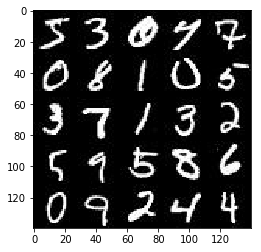

In [2]:
import helper
data_dir = './data'


show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

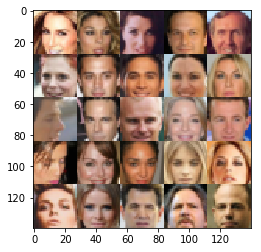

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels ), name='input_z')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_dim')
    learning_rate = tf.placeholder(tf.float32)
    
    return real, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\slava\\Anaconda3\\envs\\pyt\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\slava\\Anaconda3\\envs\\pyt\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\slava\\Anaconda3\\envs\\pyt\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\slava\\Anaconda3\\envs\\pyt\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\slava\\Anaconda3\\envs\\pyt\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "C:\\Users\\slava\\

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
       
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
            
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [47]:
def generator(z, out_channel_dim, is_train=True,alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator',reuse = (not is_train)):
        x1 = tf.layers.dense(z, 7*7*1024)
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1)
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3)

        logits =  tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #print(logits)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tensor("generator/Maximum:0", shape=(?, 7, 7, 1024), dtype=float32)
Tensor("generator/Maximum_1:0", shape=(?, 14, 14, 512), dtype=float32)
Tensor("generator/Maximum_2:0", shape=(?, 14, 14, 256), dtype=float32)
Tensor("generator/conv2d_transpose_3/BiasAdd:0", shape=(?, 28, 28, 4), dtype=float32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [27]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
mnist_dataset.shape

(60000, 28, 28, 1)

In [49]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real,input_z,lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real,input_z,data_shape[3])
    d_train_opt, g_train_opt = model_opt( d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z,lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,lr: learning_rate})
                
                steps+=1
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2950... Generator Loss: 0.2113
Epoch 1/2... Discriminator Loss: 2.0914... Generator Loss: 0.2484
Epoch 1/2... Discriminator Loss: 1.6214... Generator Loss: 0.4980
Epoch 1/2... Discriminator Loss: 1.6322... Generator Loss: 0.4878
Epoch 1/2... Discriminator Loss: 2.0479... Generator Loss: 0.3093
Epoch 1/2... Discriminator Loss: 1.6161... Generator Loss: 0.3955
Epoch 1/2... Discriminator Loss: 1.5571... Generator Loss: 0.4969
Epoch 1/2... Discriminator Loss: 1.5578... Generator Loss: 0.4270
Epoch 1/2... Discriminator Loss: 1.7941... Generator Loss: 0.6029
Epoch 1/2... Discriminator Loss: 1.7772... Generator Loss: 0.6631


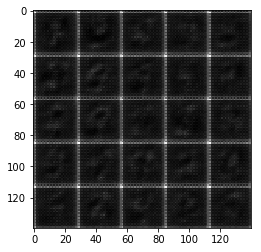

Epoch 1/2... Discriminator Loss: 1.4728... Generator Loss: 0.5573
Epoch 1/2... Discriminator Loss: 1.7276... Generator Loss: 0.3681
Epoch 1/2... Discriminator Loss: 1.4464... Generator Loss: 0.5740
Epoch 1/2... Discriminator Loss: 1.5846... Generator Loss: 0.3851
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.6867
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.7137
Epoch 1/2... Discriminator Loss: 1.5292... Generator Loss: 0.4099
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 0.4250
Epoch 1/2... Discriminator Loss: 1.3051... Generator Loss: 0.9477
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.5376


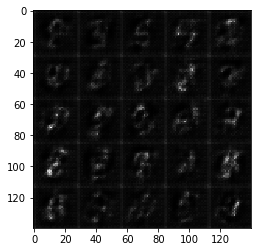

Epoch 1/2... Discriminator Loss: 1.4995... Generator Loss: 0.4168
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 0.8483
Epoch 1/2... Discriminator Loss: 1.0561... Generator Loss: 0.8253
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.5565
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 0.9510
Epoch 1/2... Discriminator Loss: 1.0199... Generator Loss: 0.9959
Epoch 1/2... Discriminator Loss: 1.1672... Generator Loss: 0.7488
Epoch 1/2... Discriminator Loss: 1.4419... Generator Loss: 0.4513
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 0.5484


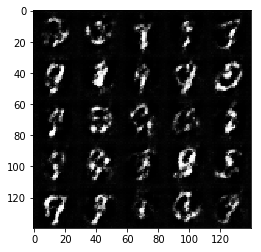

Epoch 1/2... Discriminator Loss: 0.9991... Generator Loss: 0.6388
Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 0.9541
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.5346
Epoch 1/2... Discriminator Loss: 0.9156... Generator Loss: 0.8214
Epoch 1/2... Discriminator Loss: 1.0932... Generator Loss: 0.6000
Epoch 1/2... Discriminator Loss: 1.1057... Generator Loss: 0.5918
Epoch 1/2... Discriminator Loss: 1.1162... Generator Loss: 0.6112
Epoch 1/2... Discriminator Loss: 0.9151... Generator Loss: 0.8476
Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 0.8542


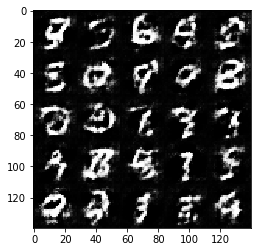

Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 0.5387
Epoch 1/2... Discriminator Loss: 0.7494... Generator Loss: 1.0123
Epoch 1/2... Discriminator Loss: 1.1011... Generator Loss: 0.7124
Epoch 1/2... Discriminator Loss: 1.1825... Generator Loss: 0.6006
Epoch 1/2... Discriminator Loss: 1.1327... Generator Loss: 0.7544
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 1.0250
Epoch 1/2... Discriminator Loss: 0.9290... Generator Loss: 0.9751
Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 0.8179
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.5269
Epoch 1/2... Discriminator Loss: 1.4431... Generator Loss: 0.3794


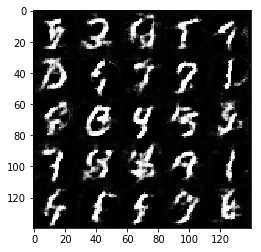

Epoch 1/2... Discriminator Loss: 1.2239... Generator Loss: 0.9504
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 0.4406
Epoch 1/2... Discriminator Loss: 1.0454... Generator Loss: 1.2199
Epoch 1/2... Discriminator Loss: 1.0479... Generator Loss: 0.6687
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 1.3650
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 1.0322
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 0.7441
Epoch 1/2... Discriminator Loss: 1.1615... Generator Loss: 0.8358
Epoch 1/2... Discriminator Loss: 0.9785... Generator Loss: 1.1962
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.4891


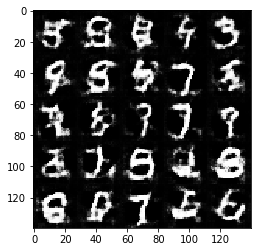

Epoch 1/2... Discriminator Loss: 1.2432... Generator Loss: 0.6935
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 0.7848
Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 0.6047
Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 0.8765
Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 0.6494
Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 0.5080
Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 1.2574
Epoch 1/2... Discriminator Loss: 0.8612... Generator Loss: 0.8802
Epoch 1/2... Discriminator Loss: 1.3383... Generator Loss: 0.5240
Epoch 1/2... Discriminator Loss: 0.9928... Generator Loss: 1.1176


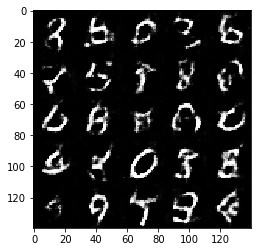

Epoch 1/2... Discriminator Loss: 1.3681... Generator Loss: 0.4590
Epoch 1/2... Discriminator Loss: 1.2565... Generator Loss: 0.6625
Epoch 1/2... Discriminator Loss: 1.3051... Generator Loss: 0.5077
Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 1.0002
Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 0.8943... Generator Loss: 0.8647
Epoch 1/2... Discriminator Loss: 0.9354... Generator Loss: 1.0463
Epoch 1/2... Discriminator Loss: 1.2531... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 0.6059


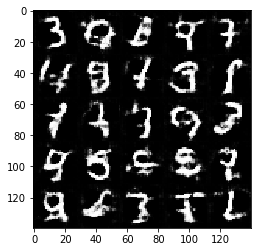

Epoch 1/2... Discriminator Loss: 1.0670... Generator Loss: 1.1290
Epoch 1/2... Discriminator Loss: 1.1077... Generator Loss: 0.6788
Epoch 1/2... Discriminator Loss: 1.2009... Generator Loss: 0.6378
Epoch 1/2... Discriminator Loss: 1.0734... Generator Loss: 1.0245
Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 0.6181
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 0.7218
Epoch 1/2... Discriminator Loss: 1.4886... Generator Loss: 0.3310
Epoch 1/2... Discriminator Loss: 1.1143... Generator Loss: 0.6960
Epoch 1/2... Discriminator Loss: 1.1454... Generator Loss: 0.7894


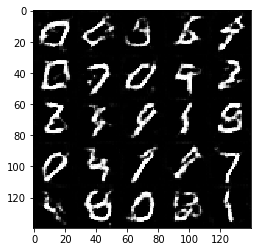

Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 0.5870
Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 0.9545
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 0.7592
Epoch 1/2... Discriminator Loss: 1.5979... Generator Loss: 0.3531
Epoch 1/2... Discriminator Loss: 1.1479... Generator Loss: 1.1364
Epoch 1/2... Discriminator Loss: 1.0117... Generator Loss: 1.1088
Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 0.7260
Epoch 1/2... Discriminator Loss: 1.0886... Generator Loss: 1.2479
Epoch 1/2... Discriminator Loss: 1.2345... Generator Loss: 0.5771
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 0.5067


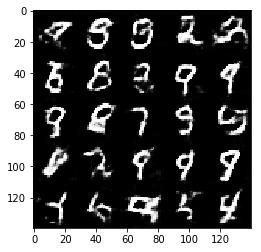

Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 0.5150
Epoch 1/2... Discriminator Loss: 1.1039... Generator Loss: 0.8417
Epoch 1/2... Discriminator Loss: 1.0193... Generator Loss: 0.6490
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 0.6187
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 1.0591
Epoch 1/2... Discriminator Loss: 1.2055... Generator Loss: 0.7597
Epoch 1/2... Discriminator Loss: 1.0607... Generator Loss: 0.7359
Epoch 1/2... Discriminator Loss: 0.9677... Generator Loss: 0.8861
Epoch 1/2... Discriminator Loss: 1.1410... Generator Loss: 0.6618
Epoch 1/2... Discriminator Loss: 1.3182... Generator Loss: 0.4605


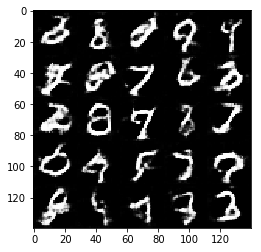

Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 0.4879
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 0.8810
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 0.6181
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.6496
Epoch 1/2... Discriminator Loss: 1.2408... Generator Loss: 0.6277
Epoch 1/2... Discriminator Loss: 0.9478... Generator Loss: 1.0914
Epoch 1/2... Discriminator Loss: 1.2157... Generator Loss: 0.5414
Epoch 1/2... Discriminator Loss: 1.0573... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 0.8969


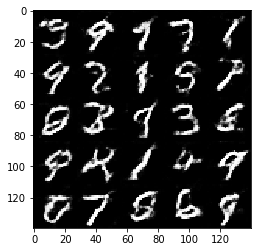

Epoch 1/2... Discriminator Loss: 1.0933... Generator Loss: 0.8316
Epoch 1/2... Discriminator Loss: 1.1525... Generator Loss: 0.9068
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 0.7308
Epoch 1/2... Discriminator Loss: 1.0885... Generator Loss: 0.7199
Epoch 1/2... Discriminator Loss: 0.9488... Generator Loss: 0.9787
Epoch 1/2... Discriminator Loss: 1.0038... Generator Loss: 0.7123
Epoch 1/2... Discriminator Loss: 1.1027... Generator Loss: 0.6056
Epoch 1/2... Discriminator Loss: 0.8659... Generator Loss: 1.0458
Epoch 1/2... Discriminator Loss: 1.1745... Generator Loss: 0.6351
Epoch 1/2... Discriminator Loss: 1.1346... Generator Loss: 0.6663


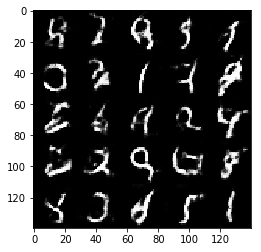

Epoch 1/2... Discriminator Loss: 0.8896... Generator Loss: 1.2852
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.4794
Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 0.7083
Epoch 1/2... Discriminator Loss: 1.0883... Generator Loss: 0.9697
Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 0.4555
Epoch 1/2... Discriminator Loss: 1.5376... Generator Loss: 0.3838
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 0.8182
Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 0.7727
Epoch 1/2... Discriminator Loss: 0.9931... Generator Loss: 0.9862
Epoch 1/2... Discriminator Loss: 1.6033... Generator Loss: 0.3190


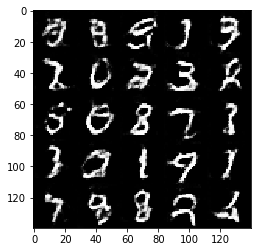

Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 1.0243
Epoch 1/2... Discriminator Loss: 0.8186... Generator Loss: 1.0559
Epoch 1/2... Discriminator Loss: 0.9705... Generator Loss: 1.2332
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.7792
Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 0.5818
Epoch 1/2... Discriminator Loss: 0.9958... Generator Loss: 0.9418
Epoch 1/2... Discriminator Loss: 1.6227... Generator Loss: 0.2683
Epoch 1/2... Discriminator Loss: 0.7346... Generator Loss: 1.1824
Epoch 1/2... Discriminator Loss: 1.2142... Generator Loss: 0.5393
Epoch 1/2... Discriminator Loss: 0.8302... Generator Loss: 1.3084


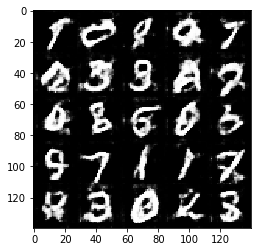

Epoch 1/2... Discriminator Loss: 1.6146... Generator Loss: 0.3110
Epoch 1/2... Discriminator Loss: 0.9538... Generator Loss: 0.8909
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 0.8965
Epoch 1/2... Discriminator Loss: 0.8568... Generator Loss: 0.8645
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 0.6233
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.7263
Epoch 1/2... Discriminator Loss: 1.0494... Generator Loss: 1.7233
Epoch 1/2... Discriminator Loss: 0.9742... Generator Loss: 1.0351
Epoch 1/2... Discriminator Loss: 0.9642... Generator Loss: 1.0874
Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 0.7158


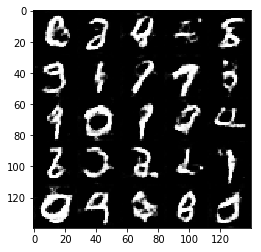

Epoch 1/2... Discriminator Loss: 1.0908... Generator Loss: 0.7444
Epoch 1/2... Discriminator Loss: 0.7899... Generator Loss: 0.8792
Epoch 1/2... Discriminator Loss: 0.9083... Generator Loss: 1.1038
Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 0.6534
Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 1.0140
Epoch 1/2... Discriminator Loss: 1.0684... Generator Loss: 0.6406
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.4847
Epoch 1/2... Discriminator Loss: 0.7510... Generator Loss: 1.0452
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 0.6798
Epoch 1/2... Discriminator Loss: 0.7429... Generator Loss: 1.1930


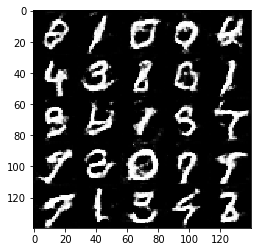

Epoch 1/2... Discriminator Loss: 0.7661... Generator Loss: 1.0435
Epoch 1/2... Discriminator Loss: 0.5501... Generator Loss: 4.3878
Epoch 1/2... Discriminator Loss: 0.8105... Generator Loss: 1.0848
Epoch 1/2... Discriminator Loss: 1.0855... Generator Loss: 1.0217
Epoch 1/2... Discriminator Loss: 0.8728... Generator Loss: 1.0851
Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 0.7873
Epoch 1/2... Discriminator Loss: 1.3427... Generator Loss: 0.4292
Epoch 1/2... Discriminator Loss: 0.8748... Generator Loss: 0.9678
Epoch 1/2... Discriminator Loss: 0.8423... Generator Loss: 0.9580
Epoch 1/2... Discriminator Loss: 0.7727... Generator Loss: 1.1990


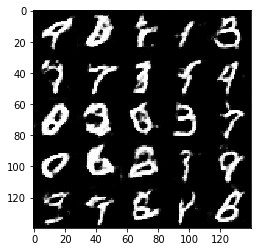

Epoch 1/2... Discriminator Loss: 1.0271... Generator Loss: 0.7172
Epoch 1/2... Discriminator Loss: 0.8960... Generator Loss: 0.7483
Epoch 1/2... Discriminator Loss: 1.4714... Generator Loss: 1.2272
Epoch 1/2... Discriminator Loss: 0.8353... Generator Loss: 0.8003
Epoch 1/2... Discriminator Loss: 1.0787... Generator Loss: 1.1321
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 0.4254
Epoch 1/2... Discriminator Loss: 0.8405... Generator Loss: 0.8802
Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 0.9031
Epoch 2/2... Discriminator Loss: 0.7782... Generator Loss: 1.1750
Epoch 2/2... Discriminator Loss: 0.6678... Generator Loss: 1.4697


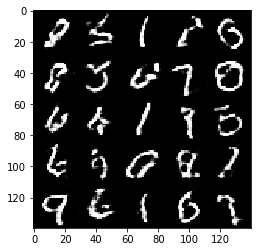

Epoch 2/2... Discriminator Loss: 0.9648... Generator Loss: 0.9408
Epoch 2/2... Discriminator Loss: 0.8533... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.1239... Generator Loss: 0.5612
Epoch 2/2... Discriminator Loss: 0.9752... Generator Loss: 0.7656
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 1.1298
Epoch 2/2... Discriminator Loss: 1.0123... Generator Loss: 0.7356
Epoch 2/2... Discriminator Loss: 1.0359... Generator Loss: 0.9276
Epoch 2/2... Discriminator Loss: 1.0999... Generator Loss: 0.6092
Epoch 2/2... Discriminator Loss: 0.8201... Generator Loss: 0.9258
Epoch 2/2... Discriminator Loss: 0.7437... Generator Loss: 1.0409


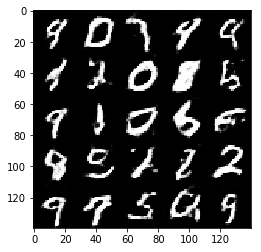

Epoch 2/2... Discriminator Loss: 0.9271... Generator Loss: 0.9942
Epoch 2/2... Discriminator Loss: 0.7816... Generator Loss: 1.0586
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 0.5264
Epoch 2/2... Discriminator Loss: 0.7786... Generator Loss: 1.0552
Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 0.8414
Epoch 2/2... Discriminator Loss: 0.7949... Generator Loss: 0.9552
Epoch 2/2... Discriminator Loss: 0.8967... Generator Loss: 1.0519
Epoch 2/2... Discriminator Loss: 1.2734... Generator Loss: 0.4530
Epoch 2/2... Discriminator Loss: 0.8139... Generator Loss: 1.0097
Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.2103


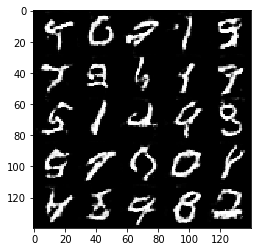

Epoch 2/2... Discriminator Loss: 1.3768... Generator Loss: 0.3864
Epoch 2/2... Discriminator Loss: 0.6697... Generator Loss: 1.4458
Epoch 2/2... Discriminator Loss: 0.7747... Generator Loss: 1.0204
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 0.9210
Epoch 2/2... Discriminator Loss: 1.1609... Generator Loss: 0.5695
Epoch 2/2... Discriminator Loss: 1.2126... Generator Loss: 0.4467
Epoch 2/2... Discriminator Loss: 1.6295... Generator Loss: 0.2876
Epoch 2/2... Discriminator Loss: 0.9065... Generator Loss: 0.9668
Epoch 2/2... Discriminator Loss: 0.8897... Generator Loss: 0.8162
Epoch 2/2... Discriminator Loss: 0.8588... Generator Loss: 1.1679


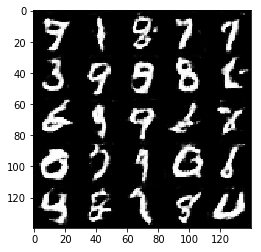

Epoch 2/2... Discriminator Loss: 1.0645... Generator Loss: 0.5773
Epoch 2/2... Discriminator Loss: 0.7384... Generator Loss: 1.5698
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 1.7414
Epoch 2/2... Discriminator Loss: 0.9900... Generator Loss: 0.6847
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 0.6121
Epoch 2/2... Discriminator Loss: 0.7620... Generator Loss: 0.9997
Epoch 2/2... Discriminator Loss: 1.1147... Generator Loss: 0.6409
Epoch 2/2... Discriminator Loss: 0.7077... Generator Loss: 1.1174
Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 1.0404
Epoch 2/2... Discriminator Loss: 0.9820... Generator Loss: 0.7710


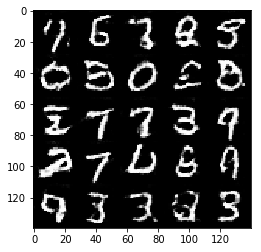

Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 1.0196
Epoch 2/2... Discriminator Loss: 1.2801... Generator Loss: 0.5618
Epoch 2/2... Discriminator Loss: 1.3981... Generator Loss: 0.5877
Epoch 2/2... Discriminator Loss: 1.1286... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 0.7204... Generator Loss: 0.9813
Epoch 2/2... Discriminator Loss: 1.0965... Generator Loss: 0.5615
Epoch 2/2... Discriminator Loss: 0.9173... Generator Loss: 0.8520
Epoch 2/2... Discriminator Loss: 1.0809... Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 0.9839... Generator Loss: 0.7270
Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 0.5481


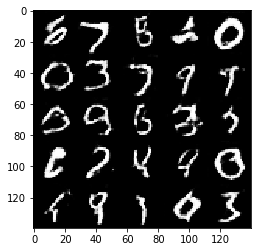

Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 1.1779
Epoch 2/2... Discriminator Loss: 0.6986... Generator Loss: 1.4755
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 1.4291
Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 0.5075
Epoch 2/2... Discriminator Loss: 0.7766... Generator Loss: 0.8954
Epoch 2/2... Discriminator Loss: 1.4994... Generator Loss: 0.3602
Epoch 2/2... Discriminator Loss: 0.9063... Generator Loss: 0.7346
Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 1.6193... Generator Loss: 0.2922


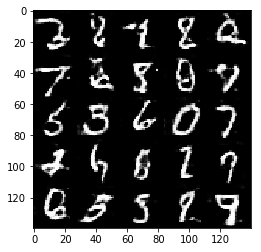

Epoch 2/2... Discriminator Loss: 1.1640... Generator Loss: 0.5751
Epoch 2/2... Discriminator Loss: 0.6988... Generator Loss: 0.9629
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 0.6118
Epoch 2/2... Discriminator Loss: 0.7852... Generator Loss: 1.0703
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 0.5145
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 0.4535
Epoch 2/2... Discriminator Loss: 0.7892... Generator Loss: 1.0535
Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 1.0002
Epoch 2/2... Discriminator Loss: 0.9808... Generator Loss: 0.6354
Epoch 2/2... Discriminator Loss: 1.0301... Generator Loss: 0.6275


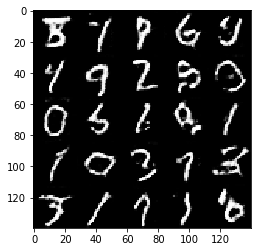

Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 0.8184
Epoch 2/2... Discriminator Loss: 0.7304... Generator Loss: 1.0815
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 0.8773... Generator Loss: 0.8460
Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 0.4487
Epoch 2/2... Discriminator Loss: 0.8926... Generator Loss: 0.7250
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 0.8037
Epoch 2/2... Discriminator Loss: 0.7937... Generator Loss: 1.0711
Epoch 2/2... Discriminator Loss: 0.6732... Generator Loss: 1.1212
Epoch 2/2... Discriminator Loss: 0.7575... Generator Loss: 1.1777


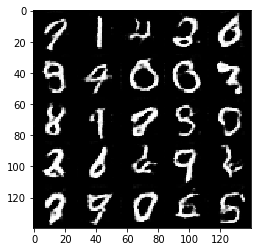

Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 0.5235
Epoch 2/2... Discriminator Loss: 1.2181... Generator Loss: 0.5311
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.3959
Epoch 2/2... Discriminator Loss: 0.7876... Generator Loss: 0.8270
Epoch 2/2... Discriminator Loss: 0.6768... Generator Loss: 1.0737
Epoch 2/2... Discriminator Loss: 0.6908... Generator Loss: 1.3028
Epoch 2/2... Discriminator Loss: 0.5241... Generator Loss: 1.5655
Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 0.6567
Epoch 2/2... Discriminator Loss: 0.8225... Generator Loss: 1.0274


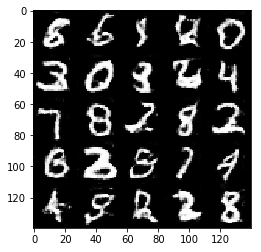

Epoch 2/2... Discriminator Loss: 1.0326... Generator Loss: 1.1392
Epoch 2/2... Discriminator Loss: 1.2474... Generator Loss: 0.4900
Epoch 2/2... Discriminator Loss: 0.6504... Generator Loss: 1.1919
Epoch 2/2... Discriminator Loss: 0.8542... Generator Loss: 1.1250
Epoch 2/2... Discriminator Loss: 0.7565... Generator Loss: 1.1661
Epoch 2/2... Discriminator Loss: 1.1506... Generator Loss: 0.5358
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 0.8444
Epoch 2/2... Discriminator Loss: 0.7437... Generator Loss: 0.9207
Epoch 2/2... Discriminator Loss: 0.6498... Generator Loss: 1.1639
Epoch 2/2... Discriminator Loss: 0.9938... Generator Loss: 0.7028


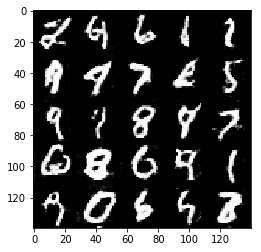

Epoch 2/2... Discriminator Loss: 1.0837... Generator Loss: 1.4673
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 0.6874
Epoch 2/2... Discriminator Loss: 0.6935... Generator Loss: 1.3393
Epoch 2/2... Discriminator Loss: 0.8264... Generator Loss: 0.9041
Epoch 2/2... Discriminator Loss: 0.7053... Generator Loss: 1.1847
Epoch 2/2... Discriminator Loss: 0.7592... Generator Loss: 0.8442
Epoch 2/2... Discriminator Loss: 0.9012... Generator Loss: 0.6964
Epoch 2/2... Discriminator Loss: 1.1458... Generator Loss: 0.5775
Epoch 2/2... Discriminator Loss: 1.2760... Generator Loss: 0.5769
Epoch 2/2... Discriminator Loss: 0.7457... Generator Loss: 1.1302


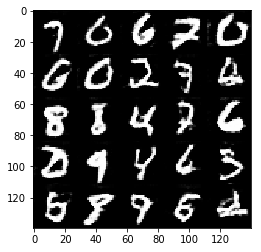

Epoch 2/2... Discriminator Loss: 0.9598... Generator Loss: 0.7083
Epoch 2/2... Discriminator Loss: 0.8112... Generator Loss: 0.9342
Epoch 2/2... Discriminator Loss: 0.7884... Generator Loss: 0.8980
Epoch 2/2... Discriminator Loss: 0.9517... Generator Loss: 0.6616
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 0.6690
Epoch 2/2... Discriminator Loss: 0.6039... Generator Loss: 1.5201
Epoch 2/2... Discriminator Loss: 0.7490... Generator Loss: 0.9104
Epoch 2/2... Discriminator Loss: 0.5993... Generator Loss: 1.2178
Epoch 2/2... Discriminator Loss: 1.4647... Generator Loss: 0.4049
Epoch 2/2... Discriminator Loss: 0.8605... Generator Loss: 0.8767


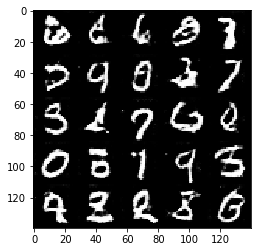

Epoch 2/2... Discriminator Loss: 0.6524... Generator Loss: 1.0850
Epoch 2/2... Discriminator Loss: 1.1403... Generator Loss: 1.3679
Epoch 2/2... Discriminator Loss: 0.8919... Generator Loss: 1.3758
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.4730
Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 0.6818
Epoch 2/2... Discriminator Loss: 0.6906... Generator Loss: 1.1073
Epoch 2/2... Discriminator Loss: 1.1415... Generator Loss: 0.6241
Epoch 2/2... Discriminator Loss: 0.8049... Generator Loss: 1.4428
Epoch 2/2... Discriminator Loss: 0.8898... Generator Loss: 0.7465
Epoch 2/2... Discriminator Loss: 0.6504... Generator Loss: 1.1301


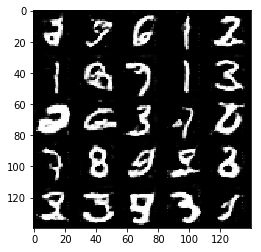

Epoch 2/2... Discriminator Loss: 0.8113... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 0.8376... Generator Loss: 1.1066
Epoch 2/2... Discriminator Loss: 1.3185... Generator Loss: 0.4893
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 1.6068
Epoch 2/2... Discriminator Loss: 0.7900... Generator Loss: 1.1188
Epoch 2/2... Discriminator Loss: 0.6547... Generator Loss: 1.1373
Epoch 2/2... Discriminator Loss: 1.0210... Generator Loss: 0.5880
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 0.6908
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.4543
Epoch 2/2... Discriminator Loss: 0.8348... Generator Loss: 1.1081


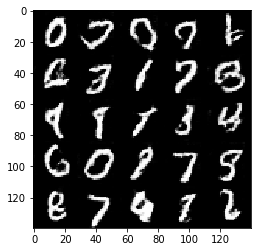

Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 1.2189
Epoch 2/2... Discriminator Loss: 0.4441... Generator Loss: 1.5874
Epoch 2/2... Discriminator Loss: 0.7804... Generator Loss: 1.1947
Epoch 2/2... Discriminator Loss: 0.8517... Generator Loss: 0.7751
Epoch 2/2... Discriminator Loss: 0.8104... Generator Loss: 1.3725
Epoch 2/2... Discriminator Loss: 0.5103... Generator Loss: 1.5403
Epoch 2/2... Discriminator Loss: 1.1018... Generator Loss: 0.6162
Epoch 2/2... Discriminator Loss: 0.9034... Generator Loss: 0.7143
Epoch 2/2... Discriminator Loss: 0.7472... Generator Loss: 1.6103
Epoch 2/2... Discriminator Loss: 0.9627... Generator Loss: 0.6423


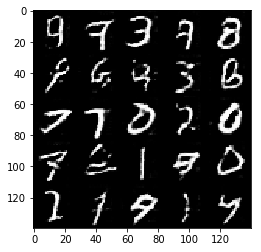

Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 0.9626... Generator Loss: 1.3305
Epoch 2/2... Discriminator Loss: 1.0453... Generator Loss: 0.5915
Epoch 2/2... Discriminator Loss: 1.7464... Generator Loss: 0.2503
Epoch 2/2... Discriminator Loss: 0.9849... Generator Loss: 0.7475
Epoch 2/2... Discriminator Loss: 1.0943... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 0.5989... Generator Loss: 1.0517
Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 1.2809
Epoch 2/2... Discriminator Loss: 0.7558... Generator Loss: 0.9147
Epoch 2/2... Discriminator Loss: 0.7266... Generator Loss: 0.9743


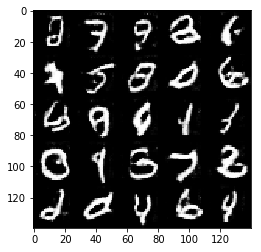

Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 1.0875
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 0.6156
Epoch 2/2... Discriminator Loss: 0.5439... Generator Loss: 1.3357
Epoch 2/2... Discriminator Loss: 0.6691... Generator Loss: 0.9738
Epoch 2/2... Discriminator Loss: 0.6132... Generator Loss: 1.3224
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 0.5628
Epoch 2/2... Discriminator Loss: 0.5554... Generator Loss: 1.1937
Epoch 2/2... Discriminator Loss: 1.5068... Generator Loss: 0.3436
Epoch 2/2... Discriminator Loss: 0.6297... Generator Loss: 1.4456


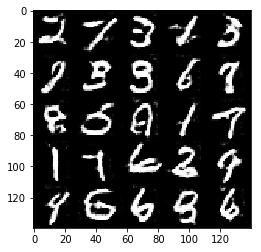

Epoch 2/2... Discriminator Loss: 0.5506... Generator Loss: 1.2560
Epoch 2/2... Discriminator Loss: 0.8195... Generator Loss: 1.2281
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 0.5840
Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 0.5729
Epoch 2/2... Discriminator Loss: 0.7144... Generator Loss: 0.8874
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 0.6546
Epoch 2/2... Discriminator Loss: 0.8873... Generator Loss: 0.7787
Epoch 2/2... Discriminator Loss: 0.6874... Generator Loss: 1.5633
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 1.2365
Epoch 2/2... Discriminator Loss: 0.6544... Generator Loss: 1.0912


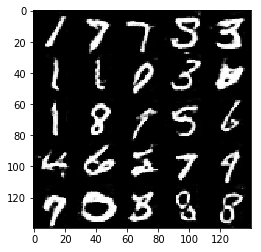

Epoch 2/2... Discriminator Loss: 0.6227... Generator Loss: 1.9179
Epoch 2/2... Discriminator Loss: 0.7129... Generator Loss: 0.9172
Epoch 2/2... Discriminator Loss: 1.1144... Generator Loss: 0.5167
Epoch 2/2... Discriminator Loss: 0.9161... Generator Loss: 0.7245
Epoch 2/2... Discriminator Loss: 1.0223... Generator Loss: 0.7972


In [50]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9976... Generator Loss: 0.3045
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.3334
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 2.2898... Generator Loss: 0.2203
Epoch 1/1... Discriminator Loss: 1.7110... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.9644... Generator Loss: 0.3854
Epoch 1/1... Discriminator Loss: 1.8710... Generator Loss: 0.4784
Epoch 1/1... Discriminator Loss: 2.6906... Generator Loss: 0.1552
Epoch 1/1... Discriminator Loss: 1.9966... Generator Loss: 0.3861
Epoch 1/1... Discriminator Loss: 1.9387... Generator Loss: 0.5553


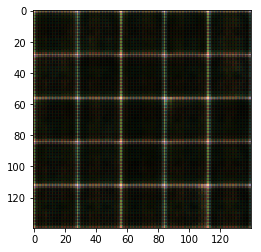

Epoch 1/1... Discriminator Loss: 2.0257... Generator Loss: 0.3762
Epoch 1/1... Discriminator Loss: 1.8686... Generator Loss: 0.3410
Epoch 1/1... Discriminator Loss: 1.7226... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 1.7690... Generator Loss: 0.4471
Epoch 1/1... Discriminator Loss: 1.6583... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.6685... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.6257... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 1.5825... Generator Loss: 0.6094


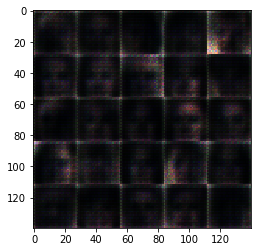

Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.6305... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.6795... Generator Loss: 0.4863
Epoch 1/1... Discriminator Loss: 1.6668... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.7296... Generator Loss: 0.3190
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7797


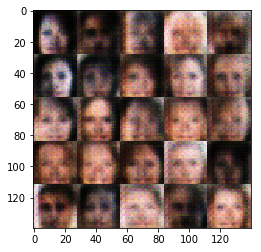

Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.1956
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 1.6875
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.5121
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 2.0572
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 2.3271
Epoch 1/1... Discriminator Loss: 2.0210... Generator Loss: 0.2480
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.9982


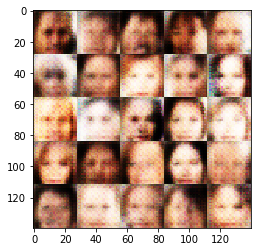

Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 2.6423
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.5403
Epoch 1/1... Discriminator Loss: 1.7578... Generator Loss: 0.2981
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 0.3411
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.3041
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 1.3522
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.7288


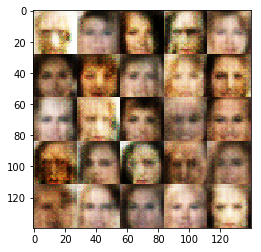

Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.7486


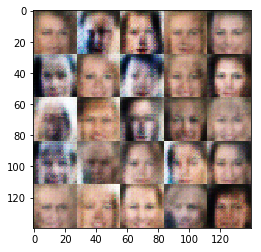

Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.5379... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.6307


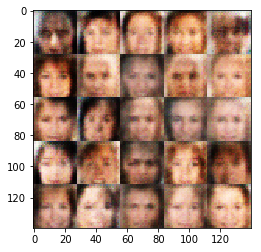

Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.6432


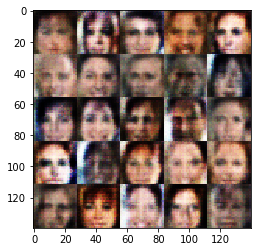

Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.5824


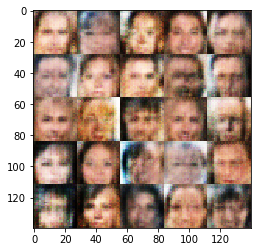

Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6546


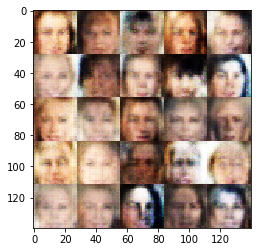

Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.6380... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.5924


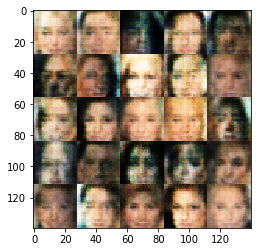

Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6674


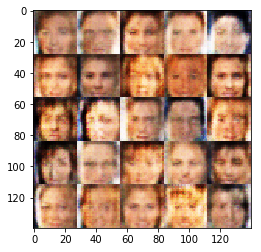

Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.5680... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.7008


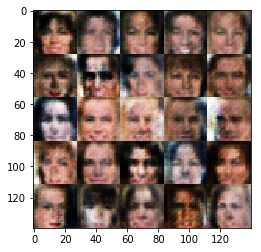

Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.6708


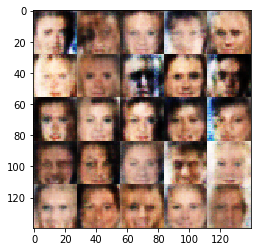

Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6428


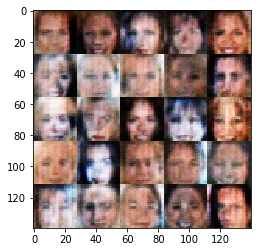

Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.6360


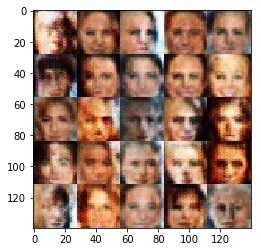

Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7517


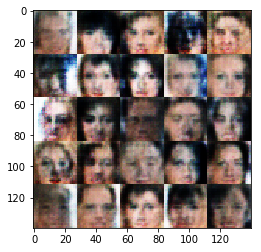

Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7053


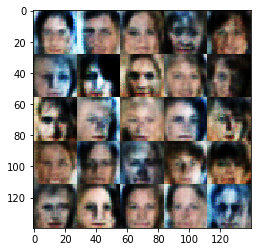

Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7101


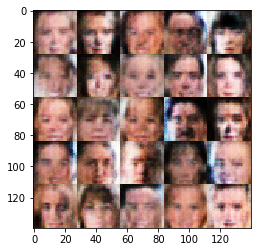

Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6736


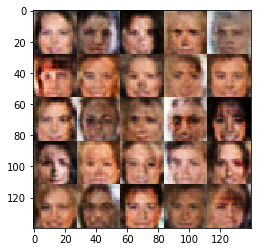

Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.6734


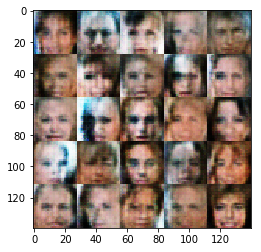

Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6113


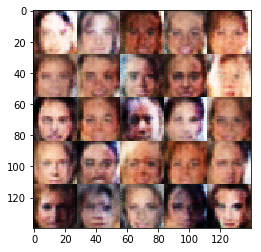

Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6295


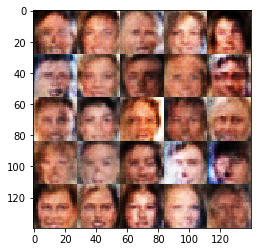

Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.5689... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.5676... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6683


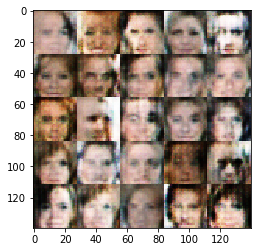

Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.5945... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6659


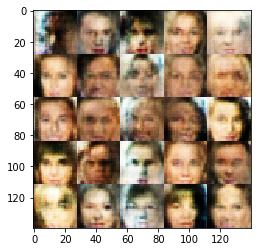

Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.7123


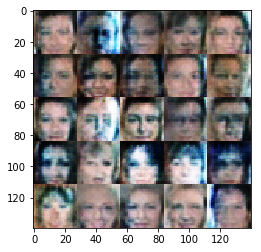

Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6996


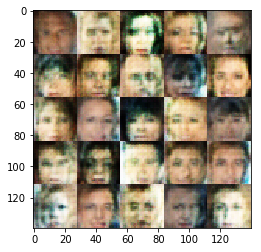

Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6725


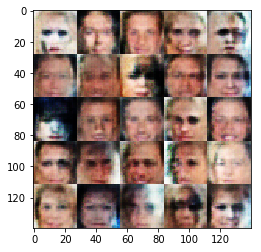

Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.7507


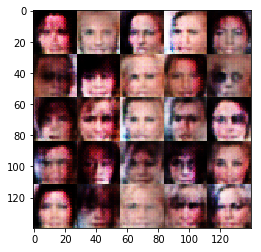

Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 1.8325
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.7682
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.6987


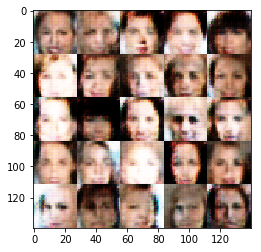

Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.9042
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.6737... Generator Loss: 0.2831
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 0.8644


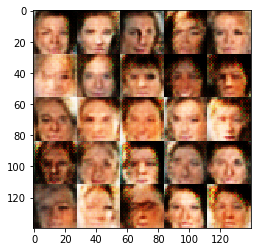

Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.7602... Generator Loss: 0.2266
Epoch 1/1... Discriminator Loss: 1.6959... Generator Loss: 0.5030
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7176


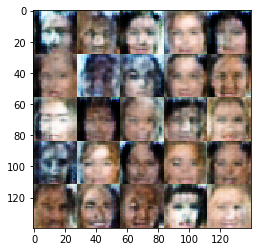

Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.5212
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.8190


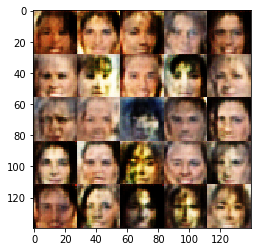

Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.7937... Generator Loss: 0.2589
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 1.3380


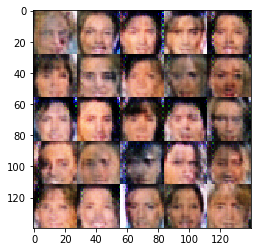

Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.3905
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.1903
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.2090
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.4554
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 1.5801
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.7559


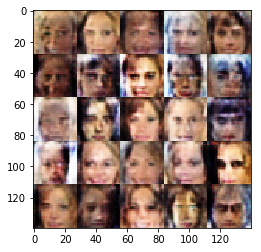

Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.6064... Generator Loss: 0.3432
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 1.3602
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.4118


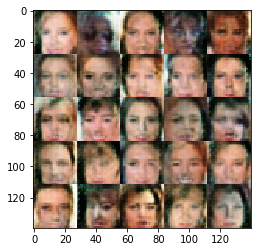

Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.4359
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.4186
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.6314


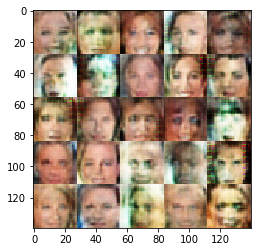

Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 1.1671
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.4756
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.9850


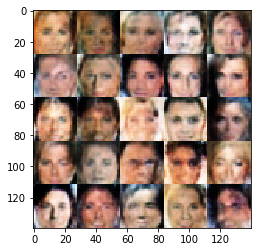

Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 1.0240


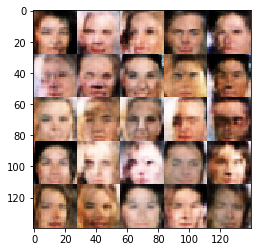

Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.5581


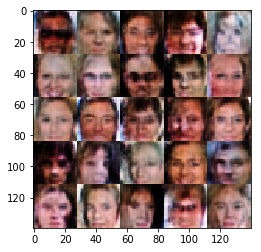

Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.0844
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.5017


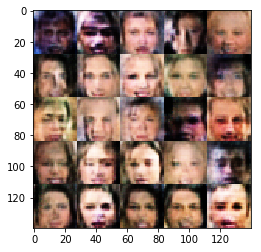

Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.5734


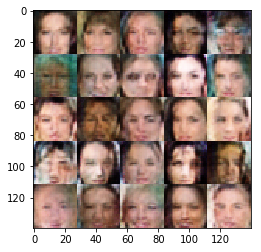

Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.9180


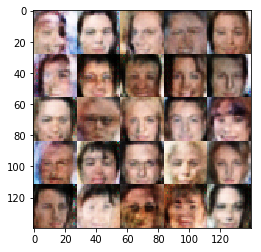

Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 1.3657
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.5027


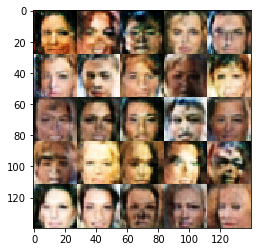

Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.6122... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.9888
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.7542


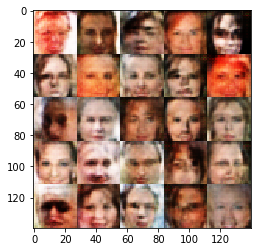

Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.6609


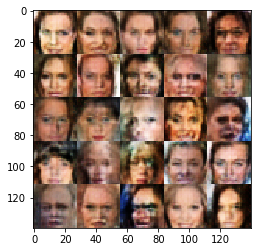

Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.7028... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.5884


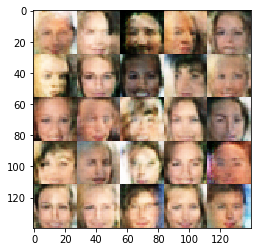

Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.8339


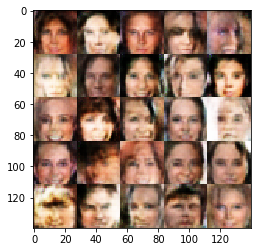

Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.5953


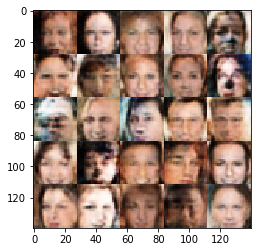

Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.4641
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.7407


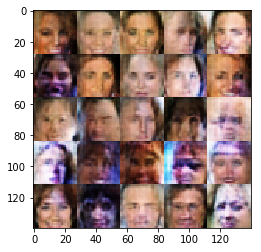

Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7499


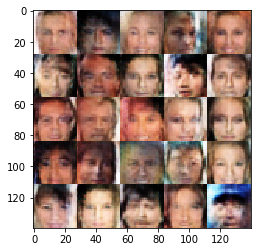

Epoch 1/1... Discriminator Loss: 1.6923... Generator Loss: 0.3504
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6713


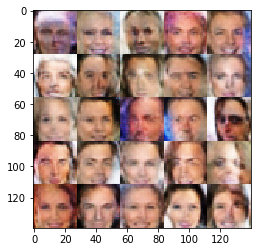

Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.3505
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8683


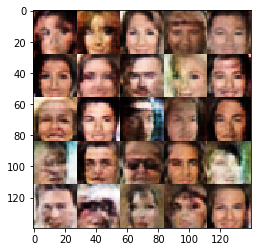

Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.5073
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 1.1899
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.6378


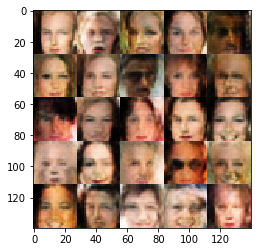

Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.5204


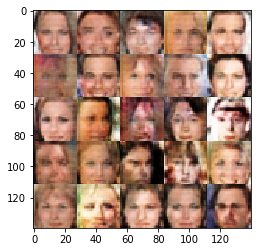

Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.4589
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.4930


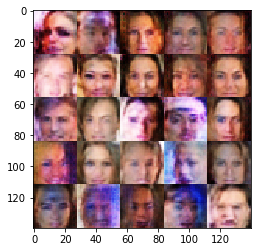

Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.8542


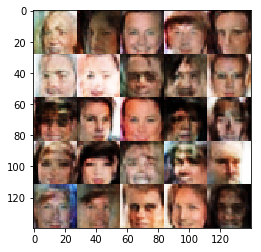

Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.4203
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.4513
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.5501


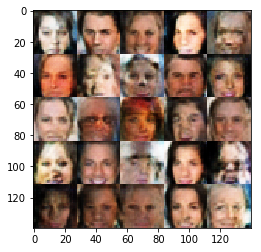

Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7318


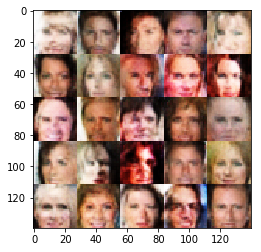

Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.4516


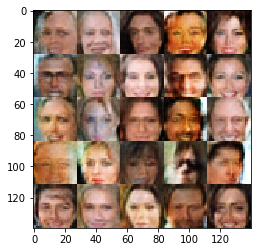

Epoch 1/1... Discriminator Loss: 1.5514... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.5757
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7022


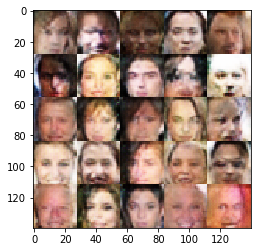

Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.5632


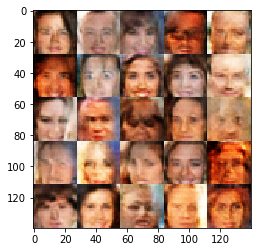

Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.6791... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.5690


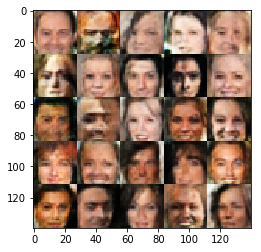

Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6623


In [52]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.